# Single allocation CFLP

**Pablo García Pérez**

En este cuaderno Jupyter, abordaremos el problema del **Single allocation CFLP**. Además, se proporcionarán algunos supuestos que ayudarán a contextualizar y comprender estas variantes, siendo estos uno para cada uno de los problemas.

___

El **CFLP** con asignación única (*single allocation*) es un problema clásico de **optimización combinatoria** en el campo de la logística y la gestión de cadenas de suministro. El objetivo principal es **determinar qué instalaciones (fábricas o almacenes) abrir** y **asignar clientes a dichas instalaciones** de tal manera que se minimicen los costos totales, cumpliendo con las capacidades de suministro de las instalaciones y las demandas de los clientes.

## Descripción del Problema
Dado:
- Un conjunto de posibles ubicaciones de **fábricas** o **almacenes**.
- Un conjunto de **clientes** con demandas específicas.
- Costos fijos asociados con la apertura de cada instalación.
- Costos variables de transporte entre las fábricas y los clientes.
- Capacidades limitadas de las fábricas para suministrar productos.

El problema busca:
1. **Seleccionar qué fábricas abrir** (considerando los costos fijos de apertura).
2. **Asignar cada cliente a exactamente una fábrica** (asignación única).
3. Minimizar el **costo total**, que incluye los costos de apertura de las fábricas y los costos de transporte entre fábricas y clientes.
4. Respetar la **capacidad máxima** de cada fábrica.


---
## Variable
Las variables que se van utilizar en este modelo son las siguientes:

yi, variable binaria que indica si la fábrica j está abierta teniendo valor 1 si está abierta o 0 en otro caso

zij, variable bienaria que indica si el cliente i está asignado a la fábrica j. Siendo 1 en ese caso 0 en el otro

xij, cantidad de producto transportada desde la fábrica j al cliente i


## Restricciones
Entre las principales restricciones son las siguientes:

1. **Restricción de Demanda** en el que cada cliente i debe recibir su demanda total
2. **Restricción de capacidad** la cantidad total enviada desde una fábrica j no puede exceder su capacidad máxima (Qij)
3. **Restricción de Asignación única** cada cliente i  debe ser asignado a una fábrica j
4. **Restricción de Asignación y Apertura** un cliente i solo puede ser asignado a una fábroca j si la fábrica está abierta

---

## Explicación Gráfica del Problema

- **Fábricas**: Representan los posibles centros de distribución con capacidad limitada y un costo fijo de apertura.
- **Clientes**: Representan la demanda que debe ser satisfecha desde una única fábrica.
- **Conexiones**: Representan las asignaciones y flujos entre fábricas abiertas y clientes, con costos de transporte asociados.

---

## Aplicaciones Prácticas

El problema **Single Allocation CFLP** es relevante en:
1. Diseño de redes de distribución (centros logísticos y almacenes).
2. Optimización de cadenas de suministro.
3. Localización de centros de servicio en sectores como telecomunicaciones, transporte y energía.
4. Planificación de instalaciones en la industria manufacturera.

---

# Resolvemos el problema

### Importamos las librerías necesarias para que pueda funcionar el código
Estas instrucciones configuran el entorno para modelar y resolver problemas de optimización matemática utilizando **JuMP** como herramienta de modelado y **GLPK** como solucionador. Además, incluyen funciones para añadir gráficos usando **GraphRecipes** y también **Plots y Graphs**

In [43]:
import Pkg
Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("Plots")


using JuMP, GLPK, Random, Plots, Random, LinearAlgebra

   Resolving package versions...
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\pablo\.julia\environments\v1.11\Manifest.toml`


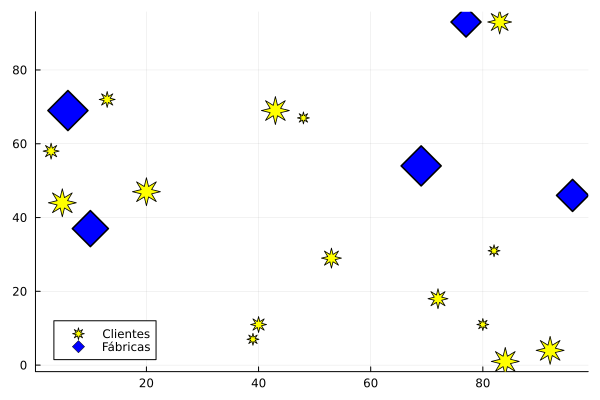

In [44]:
# --- Configuración inicial del problema de transporte ---
using Random  # Para la generación de números aleatorios
using Plots   # Para visualización de los datos

# Definimos número de clientes y posibles ubicaciones de fábricas
num_clients = 15    # Número total de clientes
num_factories = 5   # Número de ubicaciones potenciales de fábricas

# Configuración de la semilla para reproducibilidad
Random.seed!(870)

# --- Generación de datos aleatorios ---
# Coordenadas X e Y para las ubicaciones de fábricas y clientes
factory_coords = (rand(0:100, num_factories), rand(0:100, num_factories))  # Ubicaciones de fábricas
client_coords  = (rand(0:100, num_clients), rand(0:100, num_clients))      # Ubicaciones de clientes

# Matriz de costos de transporte: inicializada con ceros
transport_cost = zeros(Float32, num_clients, num_factories)

# Cálculo de los costos de transporte (distancias euclidianas redondeadas)
for client in 1:num_clients, factory in 1:num_factories
    dx = factory_coords[1][factory] - client_coords[1][client]  # Diferencia en X
    dy = factory_coords[2][factory] - client_coords[2][client]  # Diferencia en Y
    transport_cost[client, factory] = round(sqrt(dx^2 + dy^2), digits=0)  # Distancia euclidiana redondeada
end

# Costos fijos para abrir cada fábrica y sus capacidades de suministro
fixed_costs = rand(20:30, num_factories)   # Costos fijos de apertura
factory_supply = rand(15:20, num_factories) # Capacidad de producción de cada fábrica

# Demandas de los clientes
client_demand = rand(1:5, num_clients)

# --- Ajuste de la demanda si es mayor que la oferta total ---
if sum(factory_supply) < sum(client_demand)
    println("Demanda excesiva en comparación con la oferta disponible en las fábricas.")
    println("Oferta total =", sum(factory_supply), " | Demanda total =", sum(client_demand))
    scaling_factor = sum(factory_supply) / sum(client_demand)
    client_demand .= floor.(client_demand .* scaling_factor)  # Ajuste proporcional de la demanda
end

# --- Funciones de visualización ---
# Función para dibujar la instancia del problema
function plot_instance(clients, factories, supply, demand)
    client_x, client_y = clients  # Coordenadas de los clientes
    factory_x, factory_y = factories  # Coordenadas de las fábricas

    # Representación de los clientes
    fig = scatter(
        client_x, client_y,
        label = "Clientes",
        markershape = :star8,
        markercolor = :yellow,
        markersize = 2 .* (2 .+ demand),  # Tamaño de marcador en función de la demanda
    )
    
    # Representación de las fábricas con cuadrados
    scatter!(
        factory_x, factory_y,
        label = "Fábricas",
        markershape = :diamond,
        markercolor = :blue,
        markersize = supply,  # Tamaño del marcador según la oferta
        markerstrokewidth = 2
    )
    display(fig)
end

# Función para mostrar una solución con líneas de conexión entre clientes y fábricas
function plot_solution(allocation_matrix, clients, factories, supply, demand)
    client_x, client_y = clients
    factory_x, factory_y = factories

    # Representación de clientes y fábricas
    fig = scatter(
        client_x, client_y,
        label = "Clientes",
        markershape = :star8,
        markercolor = :yellow,
        markersize = 2 .* (2 .+ demand),
    )
    scatter!(
        factory_x, factory_y,
        label = "Fábricas",
        markershape = :diamond,
        markercolor = :blue,
        markersize = supply,
        markerstrokewidth = 2
    )
    
    # Conexiones entre clientes y fábricas según la asignación
    for client in 1:num_clients, factory in 1:num_factories
        if allocation_matrix[client, factory] > 1e-5  # Solo trazamos si hay asignación significativa
            plot!(
                [factory_x[factory], client_x[client]],
                [factory_y[factory], client_y[client]],
                color = :blue,
                label = nothing
            )
        end
    end
    display(fig)
end

# --- Ejecución de la visualización de la instancia ---
plot_instance(client_coords, factory_coords, factory_supply, client_demand)


### Resolvemos 

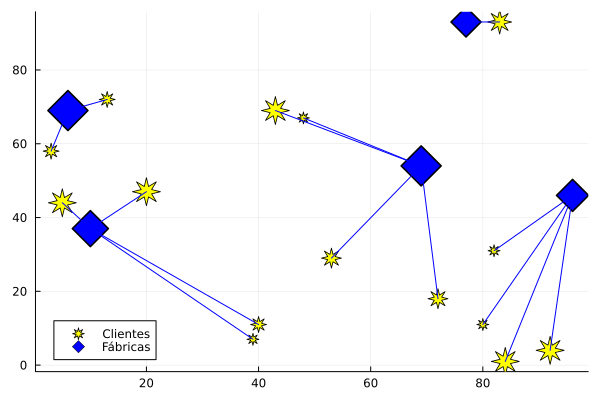

Valor objetivo óptimo: 1296.0000000000014
Costo fijo total: 120.0
Costo de transporte total: 1176.0000000000018
Visualizando solución óptima...
Fábricas abiertas:
   - Fábrica 1 abierta, suministrando 4.000000000000076 unidades.
   - Fábrica 2 abierta, suministrando 11.999999999999886 unidades.
   - Fábrica 3 abierta, suministrando 4.000000000000046 unidades.
   - Fábrica 4 abierta, suministrando 12.000000000000046 unidades.
   - Fábrica 5 abierta, suministrando 13.0 unidades.
Asignaciones cliente-fábrica:
   - Cliente 1 (demanda 1) asignado a fábrica 2 con costo de transporte 21.0
   - Cliente 2 (demanda 5) asignado a fábrica 2 con costo de transporte 42.0
   - Cliente 3 (demanda 3) asignado a fábrica 4 con costo de transporte 30.0
   - Cliente 4 (demanda 1) asignado a fábrica 2 con costo de transporte 38.0
   - Cliente 5 (demanda 2) asignado a fábrica 1 con costo de transporte 8.0
   - Cliente 6 (demanda 1) asignado a fábrica 5 con costo de transporte 42.0
   - Cliente 7 (demanda 3) 

In [45]:
# --- Función para resolver el problema de transporte con costos fijos y restricciones ---
function solve_transport_problem(num_clients, num_factories, transport_cost, fixed_costs, client_demand, factory_supply)
    EPS = 1e-5  # Tolerancia para valores pequeños
    model = Model(GLPK.Optimizer)  # Modelo de optimización con GLPK
    set_silent(model)  # Silenciar la salida del solver

    # --- Variables de decisión ---
    @variable(model, flow[1:num_clients, 1:num_factories] >= 0)  # Flujo de producto de fábrica a cliente
    @variable(model, factory_open[1:num_factories], Bin)        # Estado binario de apertura de fábrica
    @variable(model, assign[1:num_clients, 1:num_factories], Bin)  # Asignación binaria cliente-fábrica

    # --- Función objetivo ---
    @objective(model, Min, sum(fixed_costs[j] * factory_open[j] for j in 1:num_factories) +
                            sum(transport_cost[i, j] * flow[i, j] for i in 1:num_clients, j in 1:num_factories))

    # --- Restricciones ---
    # Restricción de demanda: cada cliente debe recibir su demanda total
    @constraint(model, [i in 1:num_clients], sum(flow[i, :]) == client_demand[i])

    # Restricción de capacidad: cada fábrica no puede exceder su oferta si está abierta
    @constraint(model, [j in 1:num_factories], sum(flow[:, j]) <= factory_supply[j] * factory_open[j])

    # Restricción de asignación: un cliente se puede asignar a una única fábrica
    @constraint(model, [i in 1:num_clients], sum(assign[i, :]) == 1)

    # Flujo solo permitido si el cliente está asignado a la fábrica
    @constraint(model, [i in 1:num_clients, j in 1:num_factories], flow[i, j] <= client_demand[i] * assign[i, j])

    # Asignación solo posible si la fábrica está abierta
    @constraint(model, [i in 1:num_clients, j in 1:num_factories], assign[i, j] <= factory_open[j])

    # --- Optimizar el modelo ---
    optimize!(model)

    # --- Mostrar la solución ---
    if termination_status(model) == OPTIMAL
        println("Valor objetivo óptimo: ", objective_value(model))
        println("Costo fijo total: ", sum(fixed_costs .* value.(factory_open)))
        println("Costo de transporte total: ", sum(transport_cost .* value.(flow)))

        # Extraer resultados
        flow_values = value.(flow)
        factory_status = value.(factory_open)

        # --- Visualización de la solución ---
        println("Visualizando solución óptima...")
        plot_solution(flow_values, client_coords, factory_coords, factory_supply, client_demand)

        # Mostrar fábricas abiertas
        println("Fábricas abiertas:")
        for j in 1:num_factories
            if factory_status[j] > EPS
                println("   - Fábrica ", j, " abierta, suministrando ", sum(flow_values[:, j]), " unidades.")
            end
        end

        # Mostrar asignación de clientes
        println("Asignaciones cliente-fábrica:")
        for i in 1:num_clients, j in 1:num_factories
            if flow_values[i, j] > EPS
                println("   - Cliente ", i, " (demanda ", client_demand[i], ") asignado a fábrica ", j, 
                        " con costo de transporte ", transport_cost[i, j])
            end
        end
    else
        println("No se encontró una solución factible.")
    end
end

# --- Ejecución de la función de resolución ---
solve_transport_problem(num_clients, num_factories, transport_cost, fixed_costs, client_demand, factory_supply)
